In [ ]:
#Questions

# 1 - Predict the average review score based on the comments provided by reviewers?
# 2 - Predict the optimal price for a listing based on its availability and historical pricing data
# 3 - Automatically generate summaries of the detailed comments provided by reviewers?


In [199]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_squared_error, r2_score
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
#from textblob import TextBlob


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alsot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alsot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df_calendar = pd.read_csv(r'archive_seatle/calendar.csv')
df_listings = pd.read_csv(r'archive_seatle/listings.csv')
df_reviews = pd.read_csv(r'archive_seatle/reviews.csv')

In [169]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [167]:
df_listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [ ]:
df_listings['id'].drop_duplicates().shape

In [168]:
df_listings_scores = df_listings[['id',
'review_scores_rating',
'review_scores_accuracy',
'review_scores_cleanliness',
'review_scores_checkin',
'review_scores_communication',
'review_scores_location' ,      
'review_scores_value']]

In [187]:
def graph_null_values(df):
    #find percentage of missing values for each column
    missing_df = df.isnull().mean()*100

    #filter out only columns, which have missing values
    missing_df_only = missing_df[missing_df > 0]

    #plot the results
    missing_df_only.plot.bar(title='Missing values, %')

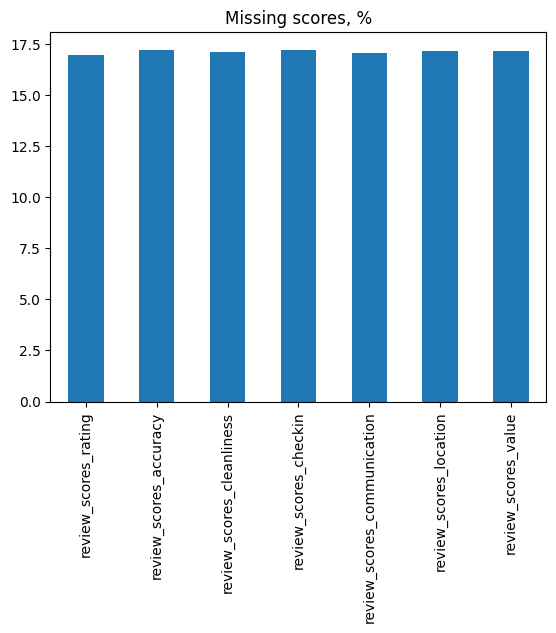

In [130]:
graph_null_values(df_listings_scores)

In [191]:
df_reviews.dropna(subset=['comments'],inplace = True)
df_listings_scores.dropna(subset=['review_scores_rating'],inplace = True)
df_merged = pd.merge(df_listings_scores,df_reviews, left_on='id', right_on='listing_id')


C:\Users\alsot\AppData\Local\Temp\ipykernel_31448\3925656077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_scores.dropna(subset=['review_scores_rating'],inplace = True)


In [194]:
df_merged.shape

(84811, 14)

In [195]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z]", " ", text)
    
    # Tokenize the text into words
    tokens = word_tokenize(text)
    
    # Remove stopwords and perform stemming
    stemmer = PorterStemmer()
    words = [w for w in tokens if w not in stopwords.words("english")]
    stemmed = [PorterStemmer().stem(w) for w in words]
    
    # Join the cleaned words into a single string
    cleaned_text = ' '.join(stemmed)
    
    return cleaned_text

In [196]:
df_merged['cleaned_comment'] = df_merged['comments'].apply(preprocess_text)

# Split the data into training and testing sets
X = df_merged['cleaned_comment']
y = df_merged['review_scores_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectors from the comments
vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train_vectors, y_train)

# Predict review scores for the test set
y_pred = model.predict(X_test_vectors)

In [200]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 16.71534578576814
R-squared (R2): -0.002464472495461223


In [202]:
X

0        excel way around maija excel host kindli invit...
1        maija apart wonder place stay extrem comfi rel...
2               one pleasant stay travel maija wonder host
3        maija suit beauti cozi conveni locat love armc...
4        stay short pleasant porch space flat boost lot...
                               ...                        
84806    great stay jacquelin place plenti space us com...
84807    jacquelin fantast host alway quick respond que...
84808                    bottl wine chocol wait upon arriv
84809    great experi fantast space amaz valu night acc...
84810    nicer hotel total worth window view cozi room ...
Name: cleaned_comment, Length: 84811, dtype: object

In [201]:
y

0         95.0
1         95.0
2         95.0
3         95.0
4         95.0
         ...  
84806     96.0
84807     96.0
84808     80.0
84809    100.0
84810    100.0
Name: review_scores_rating, Length: 84811, dtype: float64

In [ ]:
df_calendar.price = df_calendar.price.replace('[\$,]', '', regex=True).astype(float)


In [ ]:
df_calendar.groupby()

In [ ]:
df_listings.head()

In [ ]:
df_reviews.head()

In [ ]:
df_listings.info()

In [ ]:
def clean_data(df,drop_columns):
    '''

        Function receives data frame and identifys and drop:
            Columns with the unique values
            Columns with na values
            Columns in drop_columns list 
    '''
    df_object = df.select_dtypes(include=['object'])
    df.drop(drop_columns,inplace=True,axis = 1)
    df.drop_duplicates(inplace=True)
    df.dropna(axis=1, how='all', inplace=True)
    
    for i in df.columns:
        if len(df[i].unique()) == 1:
            df.drop([i],inplace =True,axis = 1)
            

    return df

In [ ]:
url_list = []
for i in df_listings.columns:
    if 'url' in i:
        url_list.append(i)
#url_list

In [ ]:
df_listings_aux = df_listings.copy()

df_listingsnew = clean_data(df_listings_aux,url_list)

In [ ]:
sum(df_listingsnew.weekly_price.value_counts())

In [ ]:
sum(df_listingsnew.isnull())                  

In [ ]:
plt.figure(figsize=(15, 6))
((df_listingsnew.isnull().sum()/df_listingsnew.shape[0])*100).plot(kind="bar")

'Since de square feet has almost 100% of null values, we must drop that columns'

df_listingsnew = clean_data(df_listingsnew,['square_feet'])

In [ ]:
plt.figure(figsize=(15, 6))
((df_listingsnew.isnull().sum()/df_listingsnew.shape[0])*100).plot(kind="bar")